# Getting started with OnionNet

OnionNet is a wrapper around graph-tool, targeted towards large multilayered networks. This tutorial will show you how to get started.

In [1]:
import sys
import os
import pandas as pd

import onionnet
print("onionnet package located at:", onionnet.__file__)
from onionnet import OnionNet
import onionnet.visualisation
import onionnet.exporter 


import graph_tool.all as gt
from graph_tool.all import graph_draw

onionnet package located at: /Users/agjanyunlu/Documents/Metabolomics/onionnet/onionnet/__init__.py


## Inspecting data

For this example we will use a network from Netzschleuder, which is loadable via graph-tool

In [2]:
g1 = gt.collection.ns["moreno_sociograms/grade_1"]
# pos_sfdp1 = gt.sfdp_layout(g)
g1

<Graph object, directed, with 35 vertices and 67 edges, 2 internal vertex properties, 6 internal graph properties, at 0x107abb950>

In [3]:
g2 = gt.collection.ns["moreno_sociograms/grade_2"]
# pos_sfdp2 = gt.sfdp_layout(g)
g2

<Graph object, directed, with 29 vertices and 59 edges, 2 internal vertex properties, 6 internal graph properties, at 0x107abb9e0>

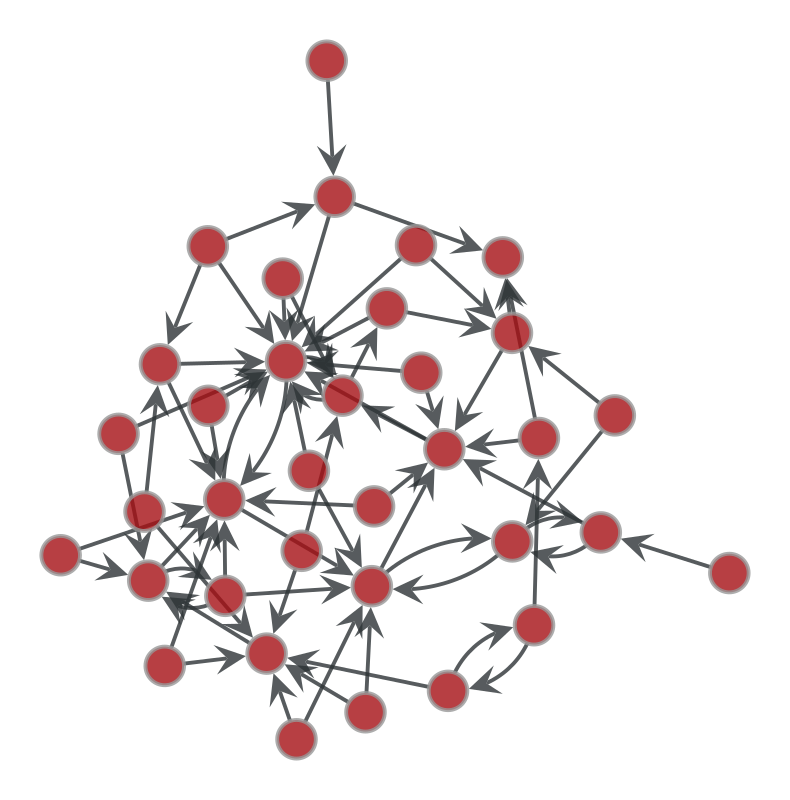

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x107abb950, at 0x15f617140>

In [4]:
graph_draw(g1, pos=g1.vp['_pos'], output_size=(400, 400))

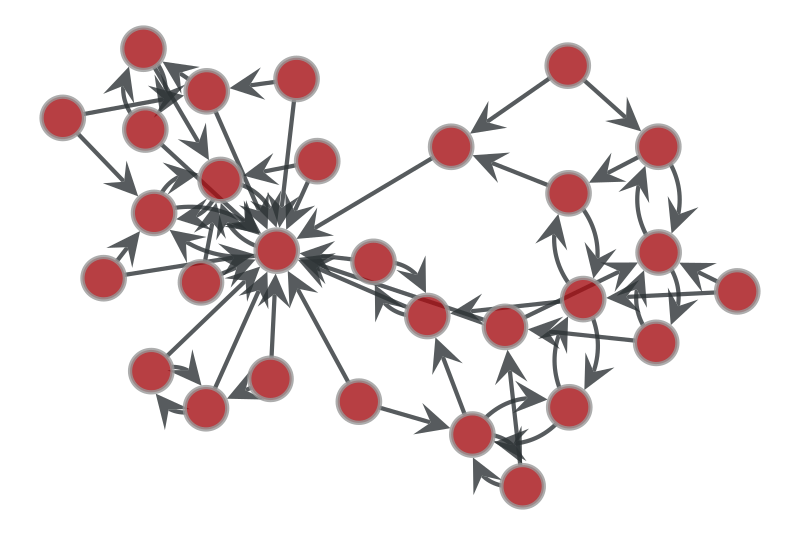

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x107abb9e0, at 0x1076af0b0>

In [5]:
graph_draw(g2, pos=g2.vp['_pos'], output_size=(400, 400))

In [6]:
list(g1.properties)

[('v', 'name'),
 ('v', '_pos'),
 ('g', 'name'),
 ('g', 'description'),
 ('g', 'citation'),
 ('g', 'url'),
 ('g', 'upstream_license'),
 ('g', 'tags')]

However the basis of OnionNet is to read data in through pandas dataframes. So we do that here now to recreate the above graph. We will also rename the columns while we're at it.

## Creating an OnionNet object using pandas dfs

In [7]:
def get_school_data(edges_or_nodes, grade, convert_to_str=False):
    if edges_or_nodes=='edges':
        df = pd.read_csv(f'../data/moreno_sociograms_grade_{grade}/edges.csv', sep=',', header=0)
        df.columns = ['source_id', 'target_id']
    elif edges_or_nodes=='nodes':
        df = pd.read_csv(f'../data/moreno_sociograms_grade_{grade}/nodes.csv', sep=',', header=0)
        df.columns = ['node_id', 'name', '_pos']
    else:
        raise ValueError("edges_or_nodes must be 'edges' or 'nodes', and a valid grade must be provided")
    # Here we will also convert all values to string
    if convert_to_str:
        for col in df.columns:
            df[col] = df[col].astype(str)
    return df

In [8]:
get_school_data('nodes', 1)

node_id name                               _pos
0         0  GO1  array([-2.98488506,  0.86791962])
1         1   LP  array([-2.95675841,  1.34825587])
2         2   PR  array([-3.55699067,  3.00557276])
3         3   WO  array([-3.34686456,  2.41781597])
4         4  FA1  array([-3.19714822,  2.96207321])
5         5   CA  array([-3.72010476,  2.18584599])
6         6   CE  array([-3.1286156 ,  1.92922718])
7         7  HN1  array([-3.61538221,  2.70444297])
8         8  FA2  array([-2.36291912,  1.56251772])
9         9   FI  array([-2.66954048,  1.51927661])
10       10   BO  array([-2.33046436,  1.82920065])
11       11  GO2  array([-2.25261004,  2.86190312])
12       12   SR  array([-2.23527893,  2.20060916])
13       13   SI  array([-2.55639663,  3.09367659])
14       14   SH  array([-3.40494624,  1.52330049])
15       15   MR  array([-3.57390615,  1.94021592])
16       16   WI  array([-3.34304401,  2.75798067])
17       17   HC  array([-2.8254759 ,  2.72389501])
18       18   RS  array([-3.62845472,  2.46067467])
19       19   DC  array([-3.04766397,  2.3163507 ])
20       20  KR2  array([-2.32950725,  2.56577117])
21       21   MB  array([-2.56942449,  2.24026267])
22       22   GA  array([-3.07328078,  2.59903076])
23       23  HN2    array([-2.9291481,  2.0509106])
24       24   SM  array([-3.92458903,  2.61466548])
25       25   BB  array([-3.09162404,  3.264659  ])
26       26   TS  array([-2.84798729,  3.16928944])
27       27   CH  array([-1.56279501,  2.67753744])
28       28   CN  array([-2.01671429,  2.53399666])
29       29   KI  array([-3.14022439,  1.63740177])
30       30  KR1  array([-3.40303049,  2.08680426])
31       31   EL  array([-2.77249254,  1.74258002])
32       32   SA  array([-1.96716967,  2.12069928])
33       33   HF  array([-2.81761731,  2.44204682])
34       34   TA  array([-2.65097942,  1.96979804])

Now let's say we want to create a multilayered network with the different classes from the school. To do this we will need to concatenate the dataframes.

In [9]:
NUM_GRADES = 2

In [10]:
df_nodes = pd.concat([get_school_data('nodes', i).assign(
    layer=f'grade_{i}') 
    for i in range(1, NUM_GRADES+1)], ignore_index=True)
df_nodes

node_id name                                 _pos    layer
0         0  GO1    array([-2.98488506,  0.86791962])  grade_1
1         1   LP    array([-2.95675841,  1.34825587])  grade_1
2         2   PR    array([-3.55699067,  3.00557276])  grade_1
3         3   WO    array([-3.34686456,  2.41781597])  grade_1
4         4  FA1    array([-3.19714822,  2.96207321])  grade_1
..      ...  ...                                  ...      ...
59       24   SH  array([  1.60443291, -15.45916702])  grade_2
60       25   HF  array([  1.50660581, -15.28444862])  grade_2
61       26   FS  array([  1.4128519 , -15.46739683])  grade_2
62       27   AT  array([  1.83319756, -15.69773967])  grade_2
63       28   MG  array([  1.91520903, -15.22439855])  grade_2

[64 rows x 4 columns]

In [11]:
df_edges = pd.concat([get_school_data('edges', i).assign(
    source_layer=f'grade_{i}', 
    target_layer=f'grade_{i}',
    interlayer=False)
    for i in range(1, NUM_GRADES+1)], ignore_index=True)
df_edges

source_id  target_id source_layer target_layer  interlayer
0            0          1      grade_1      grade_1       False
1            1          8      grade_1      grade_1       False
2            1          6      grade_1      grade_1       False
3            2          3      grade_1      grade_1       False
4            2          4      grade_1      grade_1       False
..         ...        ...          ...          ...         ...
121         26         20      grade_2      grade_2       False
122         27          5      grade_2      grade_2       False
123         27         17      grade_2      grade_2       False
124         28          9      grade_2      grade_2       False
125         28          5      grade_2      grade_2       False

[126 rows x 5 columns]

From this we can create an OnionNet graph

In [12]:
onion1 = OnionNet()

onion1.grow_onion(df_nodes=df_nodes,
           df_edges=df_edges,
           node_prop_cols=df_nodes.columns.to_list(),
           edge_prop_cols=df_edges.columns.to_list(),
           drop_na=True,
           drop_duplicates=True)

pos_sfdp = gt.sfdp_layout(onion1.core.graph)

In [13]:
print(str(onion1.core.graph))

<Graph object, directed, with 64 vertices and 126 edges, 6 internal vertex properties, 5 internal edge properties, at 0x17575b440>


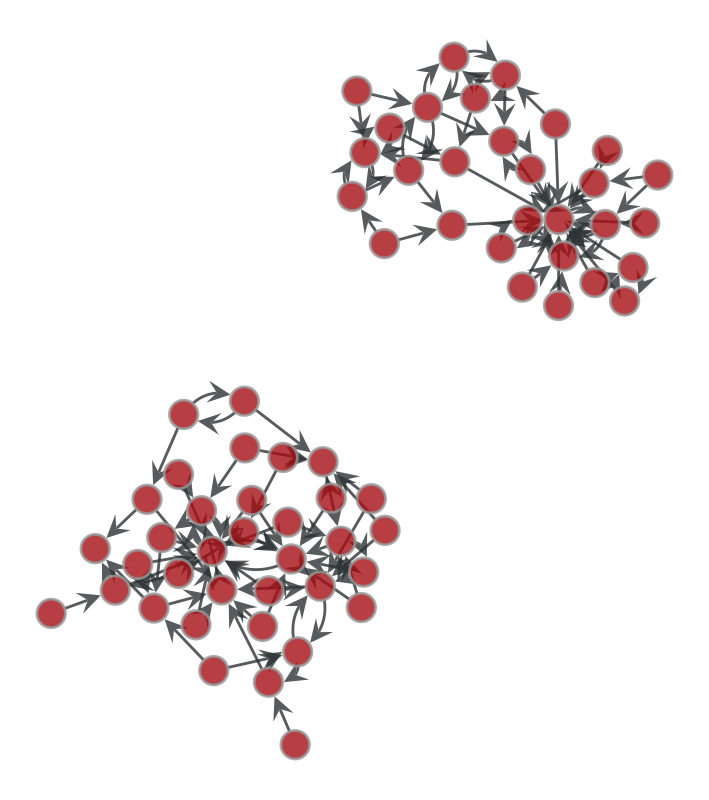

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x17575b440, at 0x17578fa70>

In [14]:
graph_draw(onion1.core.graph, pos=pos_sfdp, output_size=(400, 400))

This is nice to see we have both our layers (i.e. grades) in the network. But it's also clear to see they're disconnected. Let's simulate a scenario where some students in each grade are friends or siblings with those from other grades.

## Multiple layers with interlayer connections

In [15]:
import numpy as np
import pandas as pd

def add_random_interlayer_edges(df_nodes, df_edges, num_interlayer_edges=10, seed=42):
    """
    Add random interlayer edges to an existing edges DataFrame.
    
    Parameters:
    - df_nodes: DataFrame containing nodes with at least 'id' and 'grade' columns.
    - df_edges: Existing edges DataFrame.
    - num_interlayer_edges: Number of random interlayer edges to create.
    - seed: Random seed for reproducibility.
    
    Returns:
    - Updated df_edges with added interlayer edges.
    """
    np.random.seed(seed)
    
    # Get unique grades from the nodes DataFrame.
    grades = df_nodes['layer'].unique()
    random_edges = []
    
    for _ in range(num_interlayer_edges):
        # Randomly select two different grades.
        source_grade, target_grade = np.random.choice(grades, size=2, replace=False)
        
        # Get nodes corresponding to each grade.
        source_nodes = df_nodes[df_nodes['layer'] == source_grade]
        target_nodes = df_nodes[df_nodes['layer'] == target_grade]
        
        # If one of the grades doesn't have any nodes, skip this iteration.
        if source_nodes.empty or target_nodes.empty:
            continue
        
        # Randomly select one node from each grade (assumes 'id' column exists).
        source_node = source_nodes.sample(n=1).iloc[0]['node_id']
        target_node = target_nodes.sample(n=1).iloc[0]['node_id']
        
        # Append a new interlayer edge.
        random_edges.append({
            'source_id': source_node,
            'target_id': target_node,
            'source_layer': source_grade,
            'target_layer': target_grade,
            'interlayer': True
        })
    
    # Convert the list of random edges into a DataFrame.
    df_random_edges = pd.DataFrame(random_edges)
    
    # Concatenate the random interlayer edges with the existing edges.
    updated_df_edges = pd.concat([df_edges, df_random_edges], ignore_index=True)
    
    return updated_df_edges

# Now add random interlayer edges.
df_edges_with_friends = add_random_interlayer_edges(df_nodes, df_edges, num_interlayer_edges=10, seed=42)
df_edges_with_friends

source_id  target_id source_layer target_layer  interlayer
0            0          1      grade_1      grade_1       False
1            1          8      grade_1      grade_1       False
2            1          6      grade_1      grade_1       False
3            2          3      grade_1      grade_1       False
4            2          4      grade_1      grade_1       False
..         ...        ...          ...          ...         ...
131         17         17      grade_2      grade_1        True
132          4         15      grade_1      grade_2        True
133          9         10      grade_1      grade_2        True
134         14         26      grade_2      grade_1        True
135         10         23      grade_1      grade_2        True

[136 rows x 5 columns]

In [16]:
onion2 = OnionNet()

onion2.grow_onion(df_nodes=df_nodes,
           df_edges=df_edges_with_friends,
           node_prop_cols=df_nodes.columns.to_list(),
           edge_prop_cols=df_edges_with_friends.columns.to_list(),
           drop_na=True,
           drop_duplicates=True)

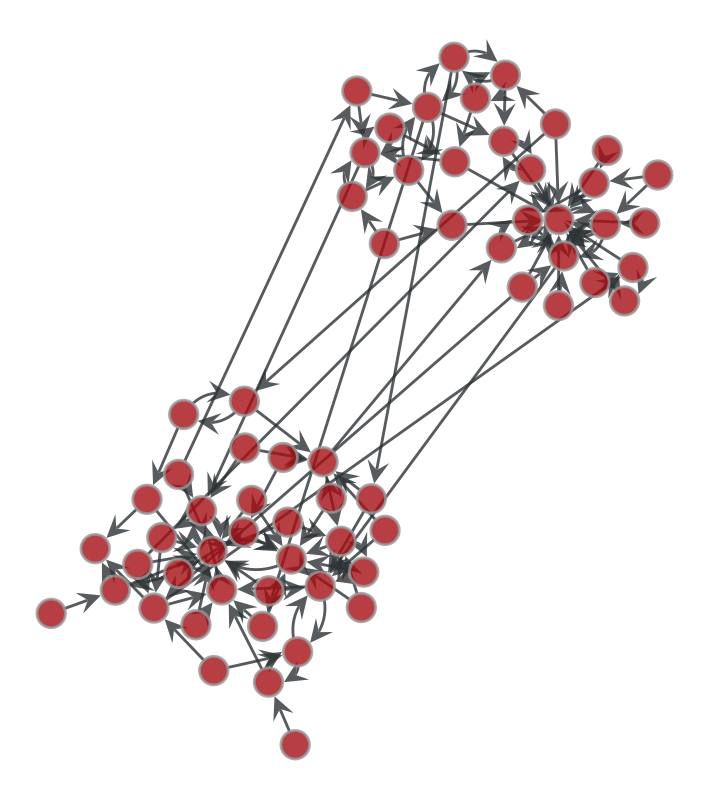

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x175758d10, at 0x17578f140>

In [17]:
graph_draw(onion2.core.graph, pos=pos_sfdp, output_size=(400, 400))

{'v_color': <VertexPropertyMap object with value type 'vector<double>', for Graph 0x175758d10, at 0x17578e810>, 'legend_node_color': None}
{'e_color': <EdgePropertyMap object with value type 'vector<double>', for Graph 0x175758d10, at 0x1743e9130>, 'legend_edge_color': None}


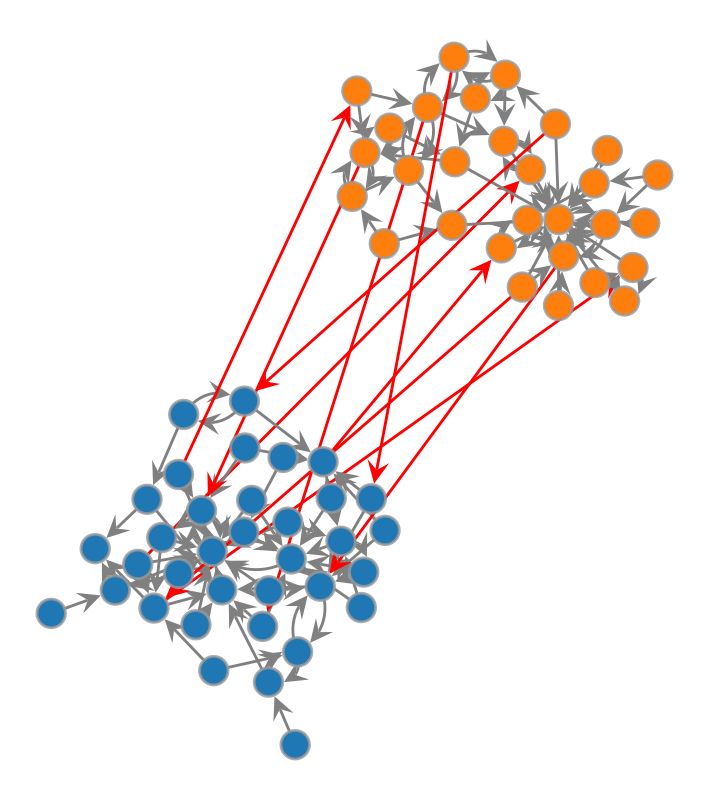

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x175758d10, at 0x16a994b00>

In [18]:
v_cols = onionnet.visualisation.color_nodes(g=onion2.core.graph, prop_name='layer')
e_cols = onionnet.visualisation.color_edges(g=onion2.core.graph, prop_name='interlayer', method='boolean')

print(v_cols)
print(e_cols)

graph_draw(onion2.core.graph, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=v_cols['v_color'], 
           edge_color=e_cols['e_color'])

Now it would be good to add labels to this to see the student names. We can do this using `vertex_text`.

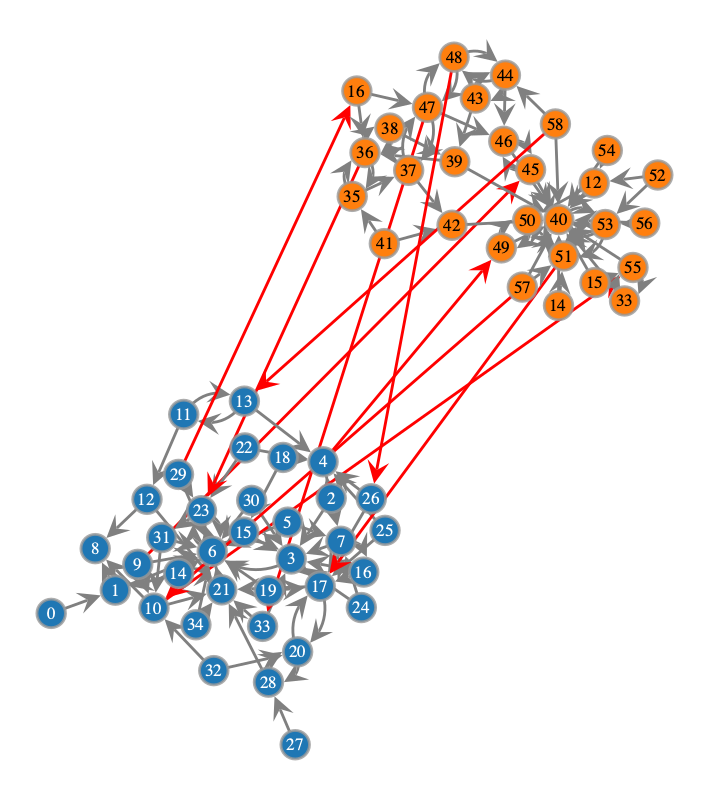

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x175758d10, at 0x17573b5c0>

In [19]:
graph_draw(onion2.core.graph, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=v_cols['v_color'], 
           edge_color=e_cols['e_color'],
           vertex_text=onion2.core.graph.vp['name'])

Oh no! Now all we have is numbers for the students. What has happened here? Let's look at our original nodes_df

In [20]:
df_nodes.groupby(['node_id', 'name']).last().drop(columns='_pos')

layer
node_id name         
0       GO1   grade_1
        ZV    grade_2
1       LP    grade_1
        MK    grade_2
2       LL    grade_2
...               ...
30      KR1   grade_1
31      EL    grade_1
32      SA    grade_1
33      HF    grade_1
34      TA    grade_1

[64 rows x 1 columns]

If we look closely we can also see that these are not the original node_ids in our plot, because in our nodes_id we had some node_ids that were actually the same for student's with different names!

So why did OnionNet treat these differently and what are the labels on the network plot? 

The answer is that behind the scenes OnionNet creates unique nodes based on both the node_id _and_ the layer. Then to improve efficiency, OnionNet encodes these values using the pandas df dtypes by default. So the node numbers we saw before are actually the mappings of these values to a dictionary we have in OnionNet. We can inspect these below.

In [21]:
onion2.core.vertex_categorical_mappings

{'node_id': {'str_to_int': {'0': 0,
   '1': 1,
   '2': 2,
   '3': 3,
   '4': 4,
   '5': 5,
   '6': 6,
   '7': 7,
   '8': 8,
   '9': 9,
   '10': 10,
   '11': 11,
   '12': 12,
   '13': 13,
   '14': 14,
   '15': 15,
   '16': 16,
   '17': 17,
   '18': 18,
   '19': 19,
   '20': 20,
   '21': 21,
   '22': 22,
   '23': 23,
   '24': 24,
   '25': 25,
   '26': 26,
   '27': 27,
   '28': 28,
   '29': 29,
   '30': 30,
   '31': 31,
   '32': 32,
   '33': 33,
   '34': 34},
  'int_to_str': {0: '0',
   1: '1',
   2: '2',
   3: '3',
   4: '4',
   5: '5',
   6: '6',
   7: '7',
   8: '8',
   9: '9',
   10: '10',
   11: '11',
   12: '12',
   13: '13',
   14: '14',
   15: '15',
   16: '16',
   17: '17',
   18: '18',
   19: '19',
   20: '20',
   21: '21',
   22: '22',
   23: '23',
   24: '24',
   25: '25',
   26: '26',
   27: '27',
   28: '28',
   29: '29',
   30: '30',
   31: '31',
   32: '32',
   33: '33',
   34: '34'}},
 'name': {'str_to_int': {'GO1': 0,
   'LP': 1,
   'PR': 2,
   'WO': 3,
   'FA1': 4,
   '

In [22]:
print(onion2.core.vertex_categorical_mappings.keys())
print(onion2.core.edge_categorical_mappings.keys())

dict_keys(['node_id', 'name', '_pos', 'layer'])
dict_keys(['source_id', 'target_id', 'source_layer', 'target_layer', 'interlayer'])


To convert these integers back into their real values we have to decode them using the `decode_property_labels` function.

In [23]:
extra_vars = ['layer', 'node_id', 'name']
for var in extra_vars:
    onion2.prop_manager.decode_property_labels(
        encoded_prop_type='v', 
        encoded_prop_name=var
    )

V property 'layer_decoded' created successfully.
V property 'node_id_decoded' created successfully.
V property 'name_decoded' created successfully.


Note that these properties will be added to the vertex or edge properties of the graph directly

In [24]:
print(list(list(onion2.core.graph.vp)))
print(list(list(onion2.core.graph.ep)))

['layer_hash', 'node_id_hash', 'node_id', 'name', '_pos', 'layer', 'layer_decoded', 'node_id_decoded', 'name_decoded']
['source_id', 'target_id', 'source_layer', 'target_layer', 'interlayer']


You won't see them and they won't be added to the vertex or edge categorical mappings (because the categorical mappings are just mappings between the encoded values, not the values of the nodes or edge properties directly)

In [25]:
print(onion2.core.vertex_categorical_mappings.keys())
print(onion2.core.edge_categorical_mappings.keys())

dict_keys(['node_id', 'name', '_pos', 'layer'])
dict_keys(['source_id', 'target_id', 'source_layer', 'target_layer', 'interlayer'])


Now that we have the decoded properties in our vertex properties of the graph, we can try drawing the graph again, this time using the `name_decoded` vertex property

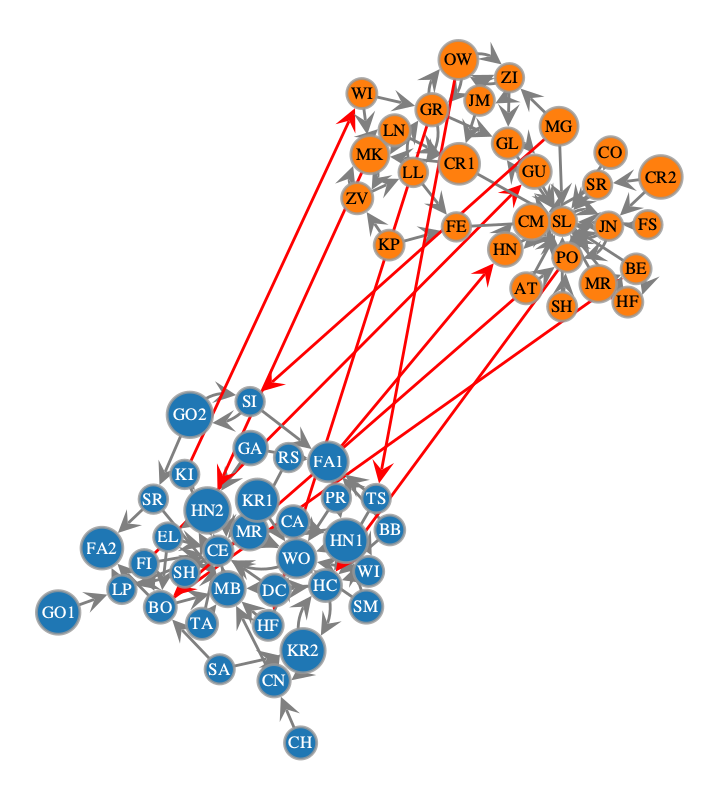

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x175758d10, at 0x17573b6e0>

In [26]:
graph_draw(onion2.core.graph, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=v_cols['v_color'], 
           edge_color=e_cols['e_color'],
           vertex_text=onion2.core.graph.vp['name_decoded'])

## Filtering the multi-layer network by layers

Now what if we want to filter the network in some ways, for example get a single layer, or multiple layers?

To filter and view certain layers of the network we can use the OnionNet `searcher.view_layers` function.

In [27]:
filtered_layers_gv = onion2.searcher.view_layers(layer_names=['grade_1'])
filtered_layers_gv

<GraphView object, directed, with 35 vertices and 67 edges, 9 internal vertex properties, 5 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x1757b29f0, at 0x1757b1970>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x1757b29f0, at 0x1757b1af0>, False), at 0x1757b29f0>

This returns a GraphView object.

We could also just create a vertex property map (but for now we will not use it)

In [28]:
filtered_layers_vpm = onion2.searcher.view_layers(layer_names=['grade_1'], return_filter=True)
filtered_layers_vpm

<VertexPropertyMap object with value type 'bool', for Graph 0x175758d10, at 0x1757b3920>

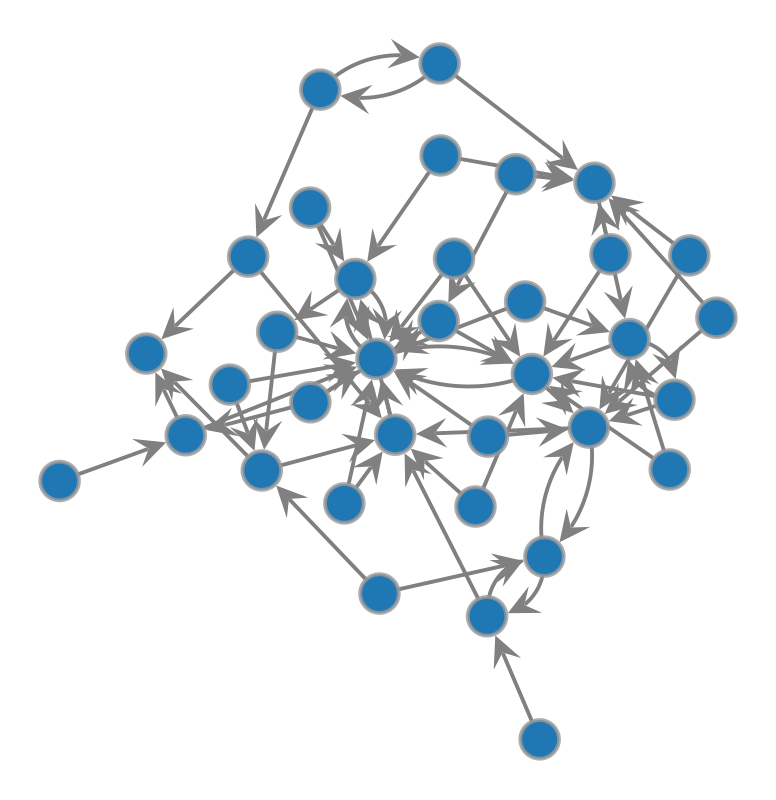

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1757b29f0, at 0x107abb620>

In [29]:
graph_draw(filtered_layers_gv, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=v_cols['v_color'], 
           edge_color=e_cols['e_color']) #,
           #vertex_text=filtered_layers.core.graph.vp['name_decoded'])

The graph view has all the same properties as before

In [30]:
list(filtered_layers_gv.vertex_properties)

['layer_hash',
 'node_id_hash',
 'node_id',
 'name',
 '_pos',
 'layer',
 'layer_decoded',
 'node_id_decoded',
 'name_decoded']

But if you try running the function below you will get an error:

`ValueError: could not broadcast input array from shape (64,) into shape (35,)`

In [31]:
# graph_draw(filtered_layers_gv, 
#            pos=pos_sfdp, 
#            output_size=(400, 400),
#            vertex_fill_color=v_cols['v_color'], 
#            edge_color=e_cols['e_color'],
#            vertex_text=filtered_layers_gv.vp['name_decoded'])

This is because the property maps that we had before for colour of the edges and nodes were for the full graph. Since these were not attached as a vertex or edge property to the graph, the filtered graph layer operation that we did has resulted in the filter being different in shape to the colour property maps.

To overcome this, we have two options:
1. recompute the vertex or edge properties using the filtered graph
2. assign the color property maps to the original graph before filtering

Your choice of these depends on whether you think you will be using the property for long or just want it on the fly

### Option 1) recalculating property maps

In [32]:
v_cols2 = onionnet.visualisation.color_nodes(g=filtered_layers_gv, prop_name='layer')
e_cols2 = onionnet.visualisation.color_edges(g=filtered_layers_gv, prop_name='interlayer', method='boolean')

print(v_cols2)
print(e_cols2)

{'v_color': <VertexPropertyMap object with value type 'vector<double>', for Graph 0x1757b29f0, at 0x17575b830>, 'legend_node_color': None}
{'e_color': <EdgePropertyMap object with value type 'vector<double>', for Graph 0x1757b29f0, at 0x175758260>, 'legend_edge_color': None}


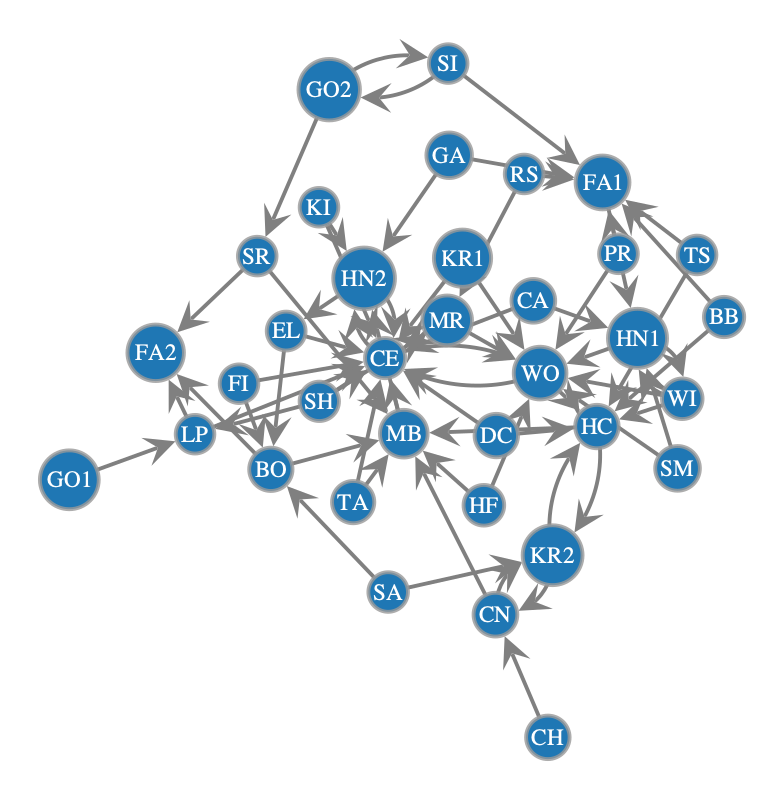

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1757b29f0, at 0x174408860>

In [33]:
graph_draw(filtered_layers_gv, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=v_cols2['v_color'], 
           edge_color=e_cols2['e_color'],
           vertex_text=filtered_layers_gv.vp['name_decoded'])

### Option 2) assigning property maps before filtering

In [34]:
onion2.core.graph.vp['v_color'] = v_cols['v_color']
onion2.core.graph.ep['e_color'] = e_cols['e_color']

In [35]:
filtered_layers_gv2 = onion2.searcher.view_layers(layer_names=['grade_1'])
filtered_layers_gv2

<GraphView object, directed, with 35 vertices and 67 edges, 10 internal vertex properties, 6 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x1757b3a70, at 0x1757d4470>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x1757b3a70, at 0x1757d46e0>, False), at 0x1757b3a70>

In [36]:
print(list(filtered_layers_gv2.vp))
print(list(filtered_layers_gv2.ep))

['layer_hash', 'node_id_hash', 'node_id', 'name', '_pos', 'layer', 'layer_decoded', 'node_id_decoded', 'name_decoded', 'v_color']
['source_id', 'target_id', 'source_layer', 'target_layer', 'interlayer', 'e_color']


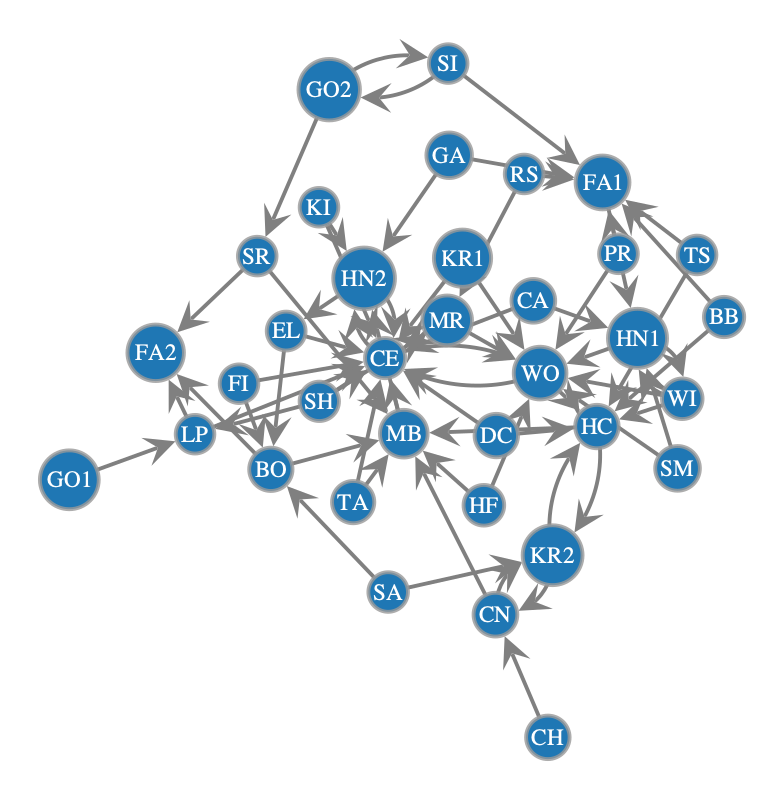

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1757b3a70, at 0x175758b00>

In [37]:
graph_draw(filtered_layers_gv2, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=filtered_layers_gv2.vp['v_color'], 
           edge_color=filtered_layers_gv2.ep['e_color'],
           vertex_text=filtered_layers_gv2.vp['name_decoded'])

## Searching and filtering the network by nodes

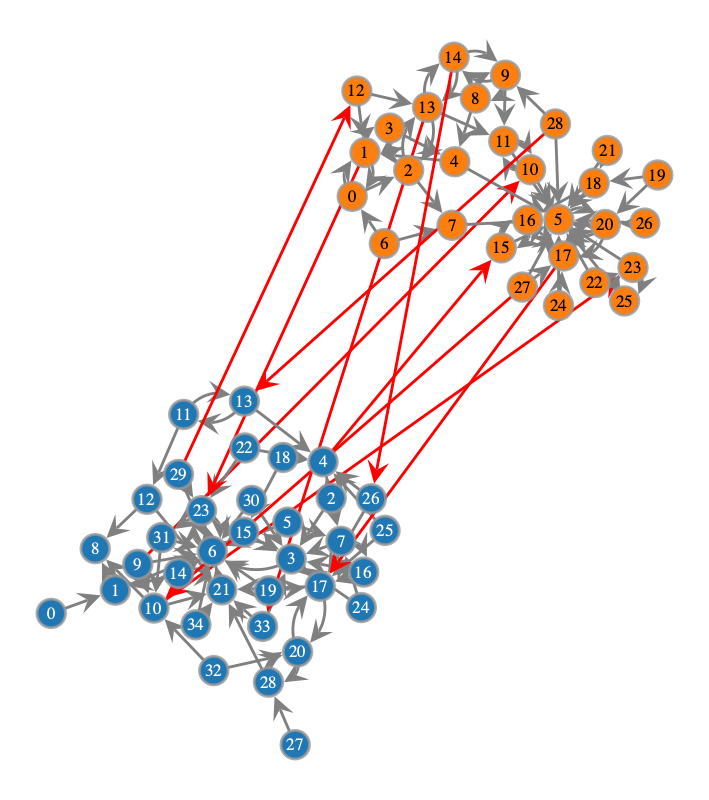

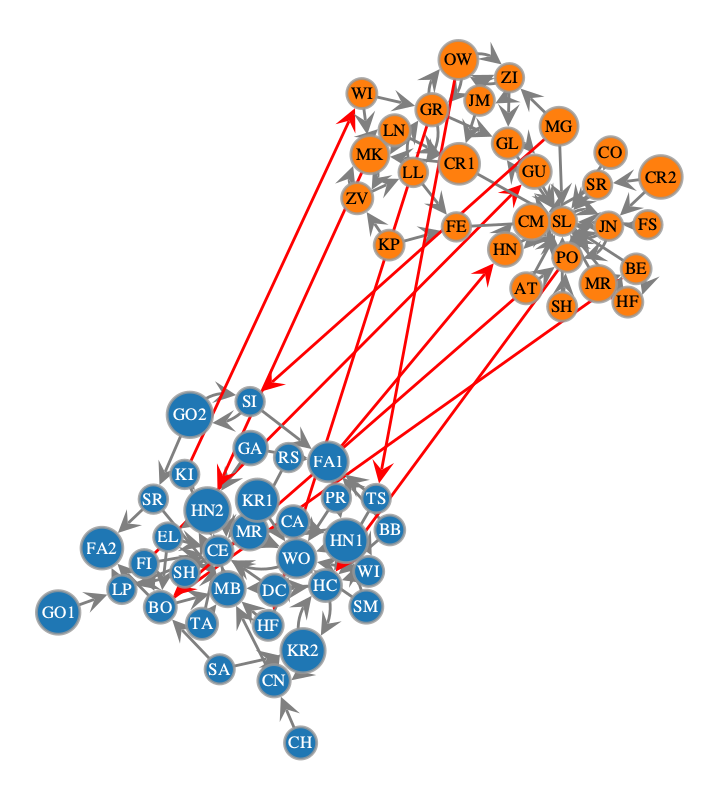

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x175758d10, at 0x17575b260>

In [38]:
graph_draw(onion2.core.graph, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=v_cols['v_color'], 
           edge_color=e_cols['e_color'],
           vertex_text=onion2.core.graph.vp['node_id'])

graph_draw(onion2.core.graph, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=v_cols['v_color'], 
           edge_color=e_cols['e_color'],
           vertex_text=onion2.core.graph.vp['name_decoded'])

Now we can run a search

Filtered graph contains 11 vertices and 18 edges.


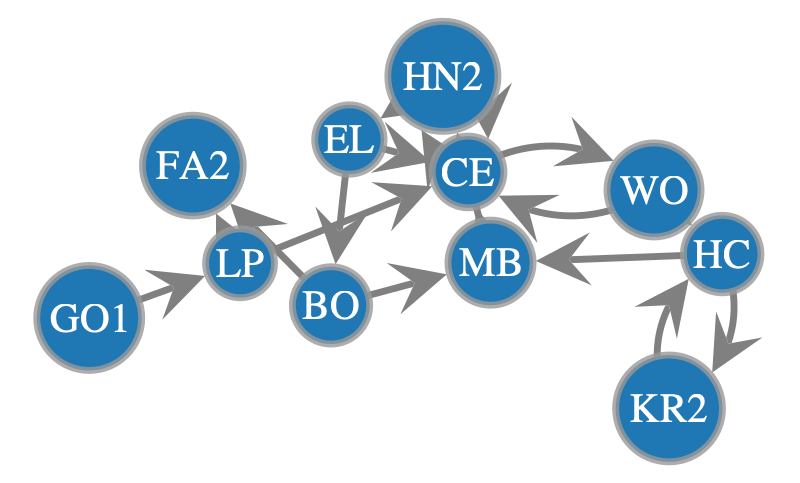

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x10c6ef7d0, at 0x1757b2150>

In [39]:
node_search_res = onion2.searcher.search(show_plot=False)

graph_draw(node_search_res, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=node_search_res.vp['v_color'], 
           edge_color=node_search_res.ep['e_color'],
           vertex_text=node_search_res.vp['name_decoded'])

By default, you will see that search used the 0 index starting node if we don't provide it with any more information. Furthermore, by default it only traverses downstream of the network up to 5 steps. We could try extending this.

Filtered graph contains 15 vertices and 26 edges.


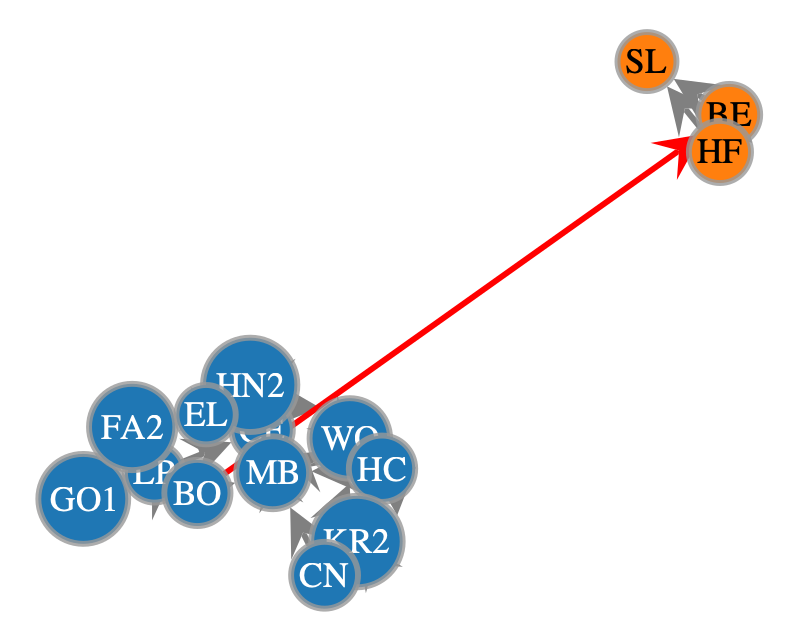

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x107abbd40, at 0x107abb8f0>

In [40]:
node_search_res = onion2.searcher.search(show_plot=False,
                                         max_dist=7)

graph_draw(node_search_res, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=node_search_res.vp['v_color'], 
           edge_color=node_search_res.ep['e_color'],
           vertex_text=node_search_res.vp['name_decoded'])

What if we extend a bit more?

Filtered graph contains 17 vertices and 33 edges.


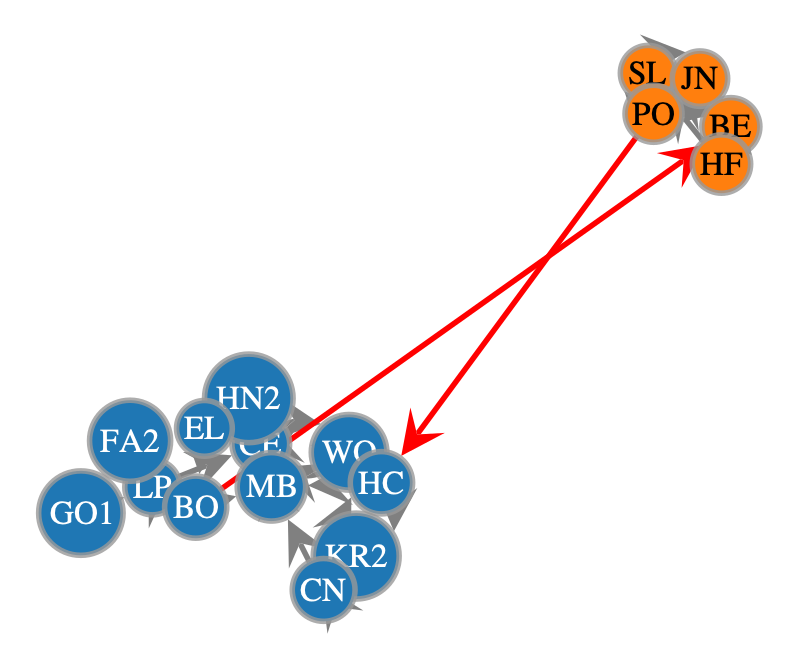

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x17575b4d0, at 0x17575b470>

In [41]:
node_search_res = onion2.searcher.search(show_plot=False,
                                         max_dist=10)

graph_draw(node_search_res, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=node_search_res.vp['v_color'], 
           edge_color=node_search_res.ep['e_color'],
           vertex_text=node_search_res.vp['name_decoded'])

We could also try starting with a different index

Filtered graph contains 3 vertices and 2 edges.


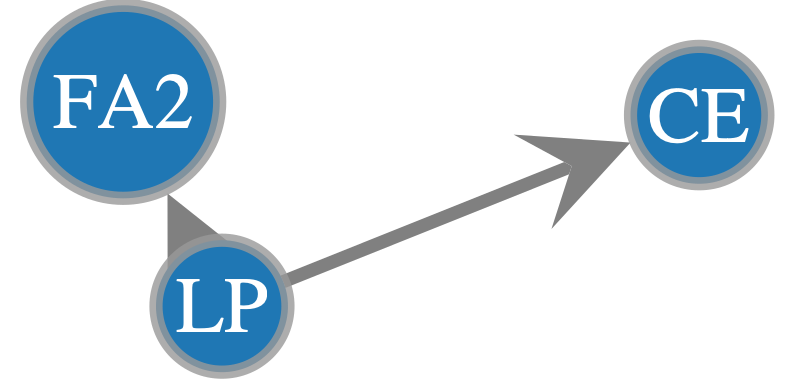

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1757d5eb0, at 0x17578d130>

In [42]:
node_search_res = onion2.searcher.search(show_plot=False,
                                         start_node_idx=1,
                                         max_dist=1)

graph_draw(node_search_res, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=node_search_res.vp['v_color'], 
           edge_color=node_search_res.ep['e_color'],
           vertex_text=node_search_res.vp['name_decoded'])

And we could also search upstream or bidirectionally

Filtered graph contains 5 vertices and 5 edges.


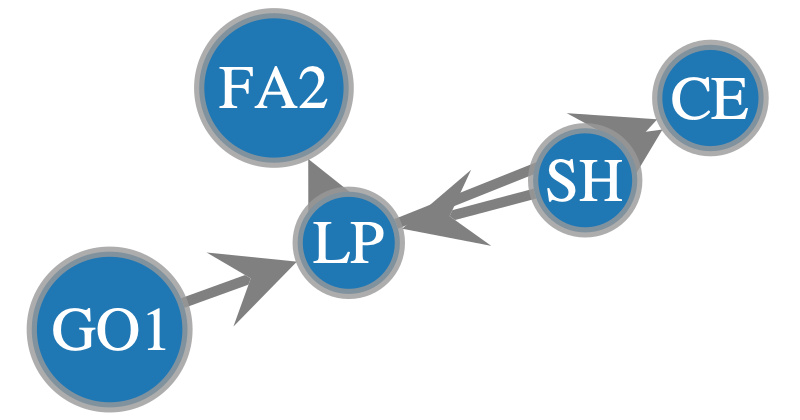

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1757b0050, at 0x17573bec0>

In [43]:
node_search_res = onion2.searcher.search(show_plot=False,
                                         start_node_idx=1,
                                         direction='bi',
                                         max_dist=1)

graph_draw(node_search_res, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=node_search_res.vp['v_color'], 
           edge_color=node_search_res.ep['e_color'],
           vertex_text=node_search_res.vp['name_decoded'])

We could also get all nodes that meet a certain condition, such as all nodes that are in a list of names.

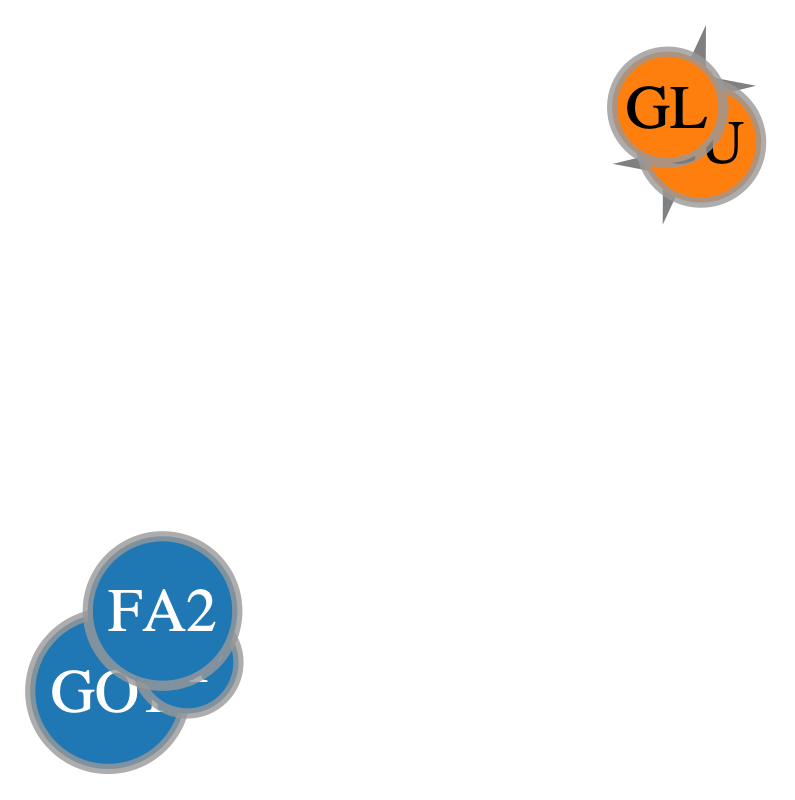

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x17573baa0, at 0x15ef057c0>

In [44]:
random_friends_gv = onion2.searcher.filter_view_by_property(
    prop_name='name_decoded', 
    target_value=['GO1', 'LP', 'FA2','GL','GU'])

graph_draw(random_friends_gv, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=random_friends_gv.vp['v_color'], 
           edge_color=random_friends_gv.ep['e_color'],
           vertex_text=random_friends_gv.vp['name_decoded'])

In [45]:
list(random_friends_gv.vertices())

[<Vertex object with index '0' at 0x1757b65c0>,
 <Vertex object with index '1' at 0x1757b79c0>,
 <Vertex object with index '8' at 0x1757b7a40>,
 <Vertex object with index '45' at 0x1757b6a40>,
 <Vertex object with index '46' at 0x1757b7240>]

In [46]:
list(random_friends_gv.vertices())[0].out_degree()

1

We could also filter the graph according to some edge attribute condition. In this case we will test with interlayer, to only show the connections between kids in the 1st and 2nd grade.

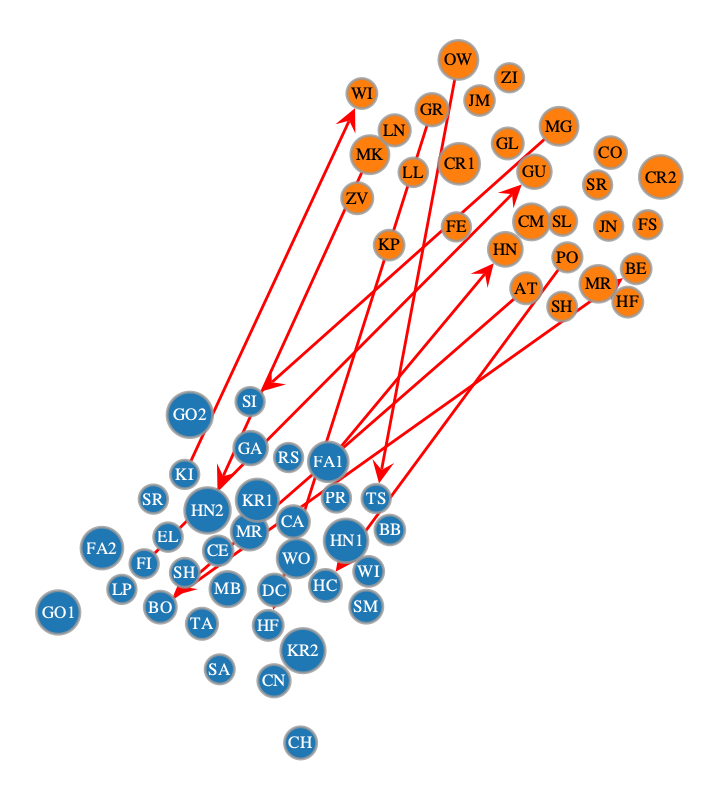

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1757d6840, at 0x175759e80>

In [47]:
interlayer_friends_gv = onion2.searcher.filter_view_by_property(
    prop_name='interlayer', 
    target_value=True,
    dim='e')

graph_draw(interlayer_friends_gv, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=interlayer_friends_gv.vp['v_color'], 
           edge_color=interlayer_friends_gv.ep['e_color'],
           vertex_text=interlayer_friends_gv.vp['name_decoded'])

Note that by default this function doesn't automatically remove the nodes that are isolated with no edges connecting them. If we want to do that we should specify `prune_isolated=True`

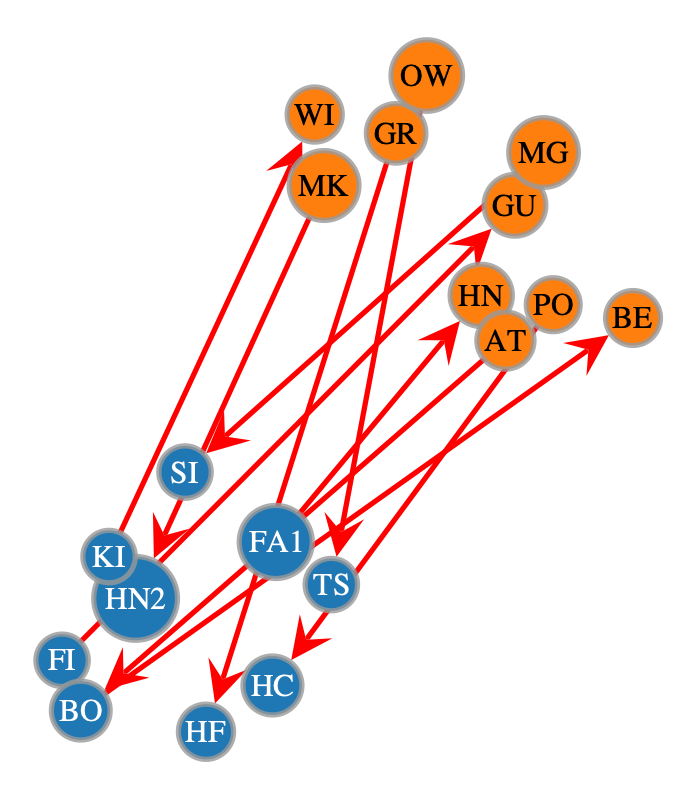

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1757f8410, at 0x1757d7e30>

In [48]:
interlayer_friends_gv_pruned = onion2.searcher.filter_view_by_property(
    prop_name='interlayer', 
    target_value=True,
    dim='e',
    prune_isolated=True)

graph_draw(interlayer_friends_gv_pruned, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=interlayer_friends_gv_pruned.vp['v_color'], 
           edge_color=interlayer_friends_gv_pruned.ep['e_color'],
           vertex_text=interlayer_friends_gv_pruned.vp['name_decoded'])

Another way that we can filter the graph, if we wish to use more advanced logic, is to use lambda functions. OnionNet provides a helper function as well to combine these functions. For instance, we could filter to have either grade_1 or grade_2:

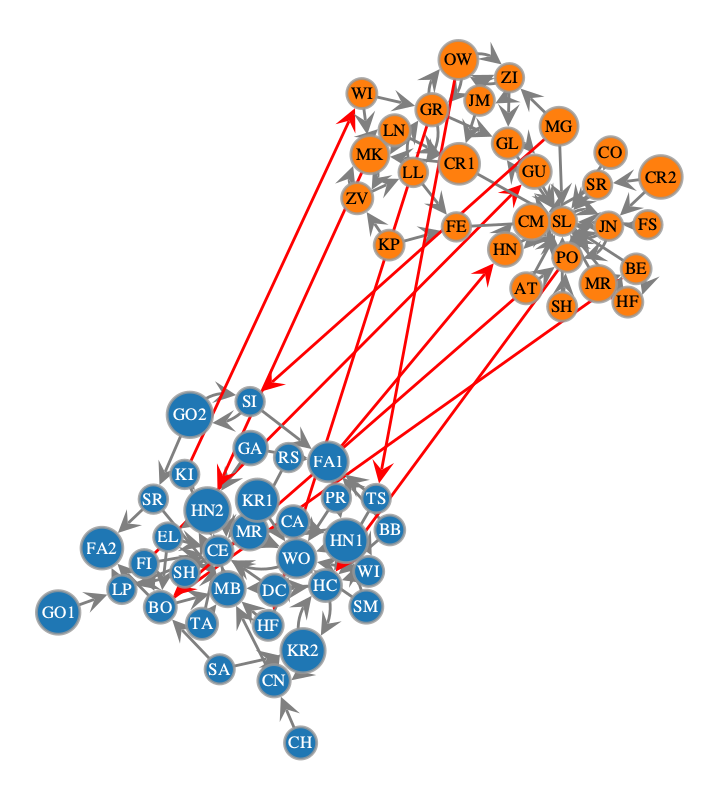

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1757d7ef0, at 0x175759b50>

In [49]:
filter1 = lambda v: onion2.core.graph.vp['layer_decoded'][v] == 'grade_1'
filter2 = lambda v: onion2.core.graph.vp['layer_decoded'][v] == 'grade_2'
filtered_view = onion2.searcher.compose_filters([filter1, filter2], mode="or")

graph_draw(filtered_view, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=filtered_view.vp['v_color'], 
           edge_color=filtered_view.ep['e_color'],
           vertex_text=filtered_view.vp['name_decoded'])

Or filter to the interlayer friends from before, but this time only show the ones in grade_1

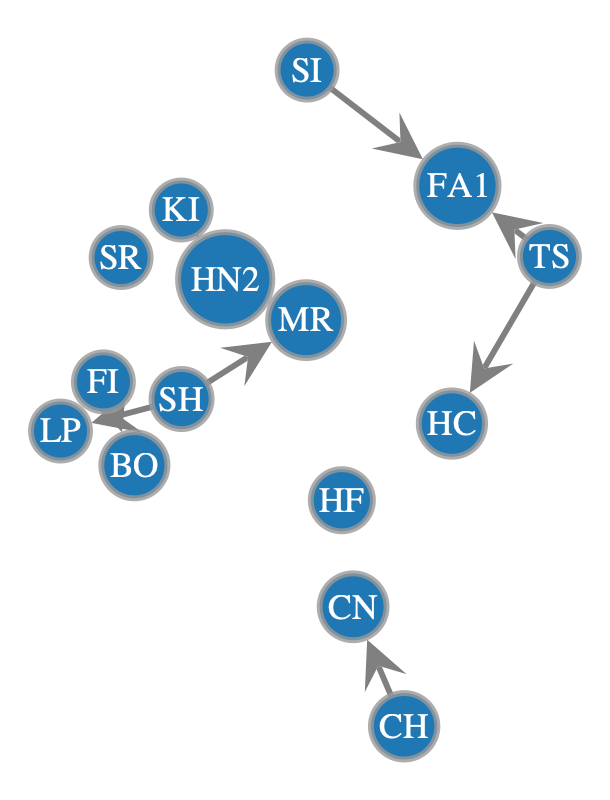

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1757fa5a0, at 0x175759a60>

In [50]:
filter1 = lambda v: onion2.core.graph.vp['layer_decoded'][v] == 'grade_1'
filter2 = lambda v: onion2.core.graph.vp['node_id'][v] in {interlayer_friends_gv_pruned.vp['node_id'][item] for item in interlayer_friends_gv_pruned.vertices()}
filtered_view = onion2.searcher.compose_filters([filter1, filter2], mode="and")

graph_draw(filtered_view, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=filtered_view.vp['v_color'], 
           edge_color=filtered_view.ep['e_color'],
           vertex_text=filtered_view.vp['name_decoded'])

## Shortest paths

In [51]:
onion2.core.graph.vertex_index

<VertexPropertyMap object with value type 'unsigned long', for Graph 0x175758d10, at 0x17578e690>

In [52]:
shortest_path_vpm = onion2.searcher.compute_on_shortest(source_idx=0, target_indices=[51,52])

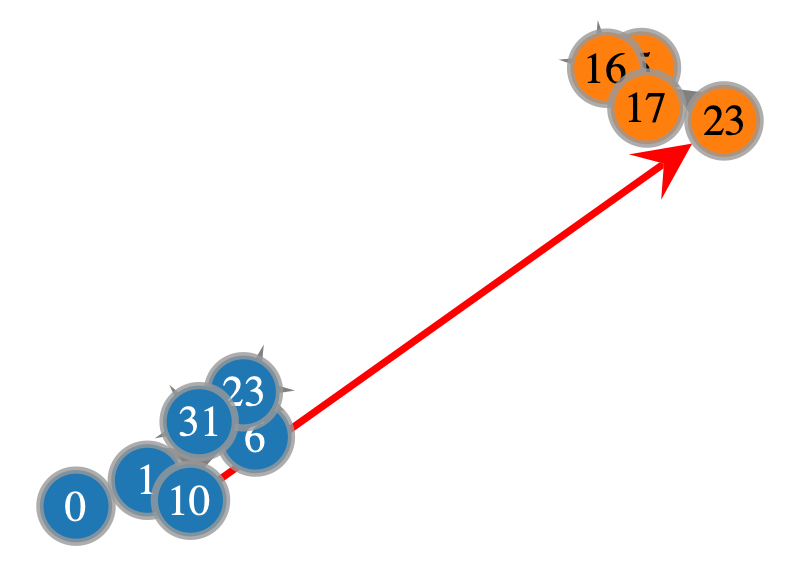

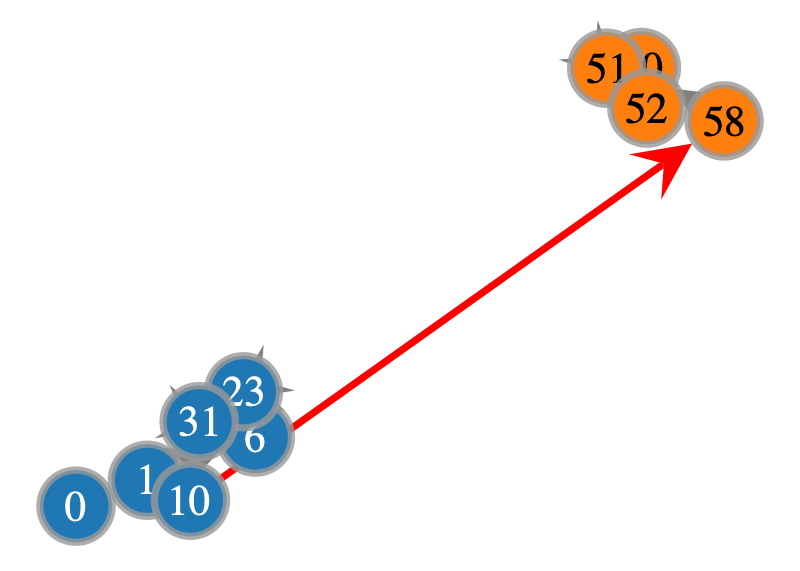

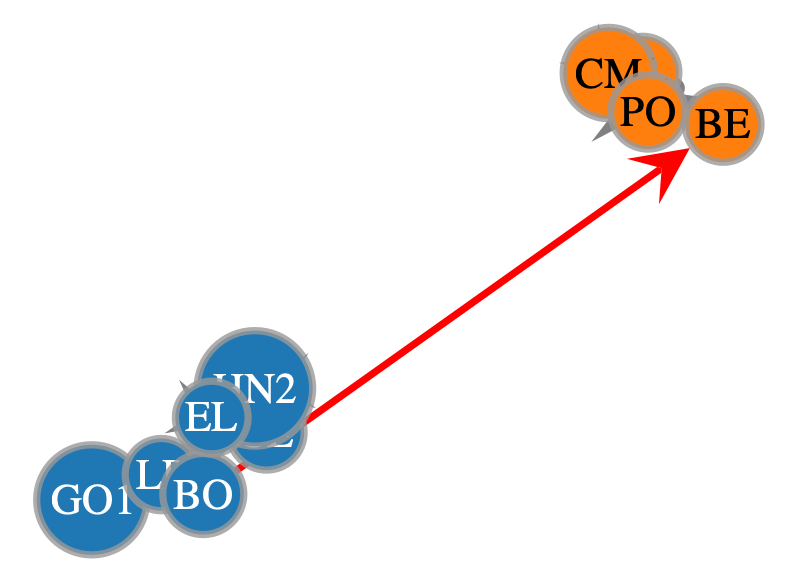

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1757b2780, at 0x1757d6480>

In [53]:
shortest_path_gv = gt.GraphView(onion2.core.graph, vfilt=shortest_path_vpm)

graph_draw(shortest_path_gv, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=shortest_path_gv.vp['v_color'], 
           edge_color=shortest_path_gv.ep['e_color'],
           vertex_text=shortest_path_gv.vp['node_id'])

graph_draw(shortest_path_gv, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=shortest_path_gv.vp['v_color'], 
           edge_color=shortest_path_gv.ep['e_color'],
           vertex_text=onion2.core.graph.vertex_index)

graph_draw(shortest_path_gv, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=shortest_path_gv.vp['v_color'], 
           edge_color=shortest_path_gv.ep['e_color'],
           vertex_text=shortest_path_gv.vp['name_decoded'])

Notice above how the vertex index is different to the category mapping of the node, which we should keep in mind.

In [54]:
print(onion2.get_vertex_by_name_tuple(layer_name='grade_1', node_id_str='0'))
print(onion2.get_vertex_by_name_tuple(layer_name='grade_2', node_id_str='0'))

0
35


Ok now what if we want to find the path between a particular index and a bunch of different indices? We can use our list(random_friends_gv.vertices()) from earlier to find connections here between these

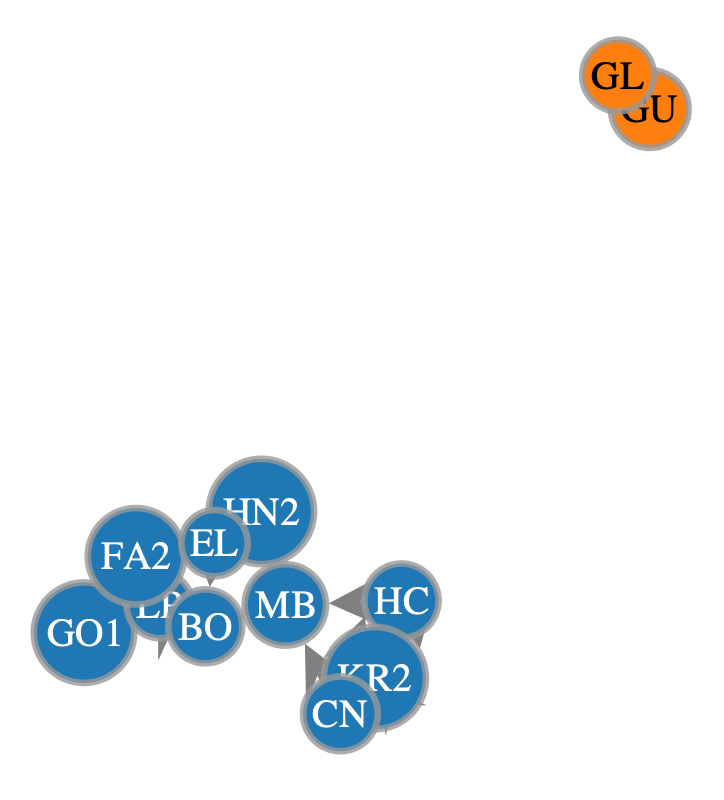

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x10c6ef7d0, at 0x17578db20>

In [55]:
random_friends_gv_idxlist = [int(item) for item in random_friends_gv.vertices()]

shortest_path_vpm2 = onion2.searcher.compute_on_shortest(source_idx=20, target_indices=random_friends_gv_idxlist)

shortest_path_gv2 = gt.GraphView(onion2.core.graph, vfilt=shortest_path_vpm2)


graph_draw(shortest_path_gv2, 
           pos=pos_sfdp, 
           output_size=(400, 400),
           vertex_fill_color=shortest_path_gv2.vp['v_color'], 
           edge_color=shortest_path_gv2.ep['e_color'],
           vertex_text=shortest_path_gv2.vp['name_decoded'])

In [56]:
onion2.core.graph.vp['node_id'].a

PropertyArray([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
               15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
               30, 31, 32, 33, 34,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
               10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
               25, 26, 27, 28], dtype=int32)

What about combining operations? So filtering to a certain layer of the network and then performing a search.

In [57]:
onion2.view_layers(['grade_1'])

<GraphView object, directed, with 35 vertices and 67 edges, 10 internal vertex properties, 6 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x1757fb1d0, at 0x1757fbce0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x1757fb1d0, at 0x1757fb980>, False), at 0x1757fb1d0>

Filtered graph contains 12 vertices and 21 edges.


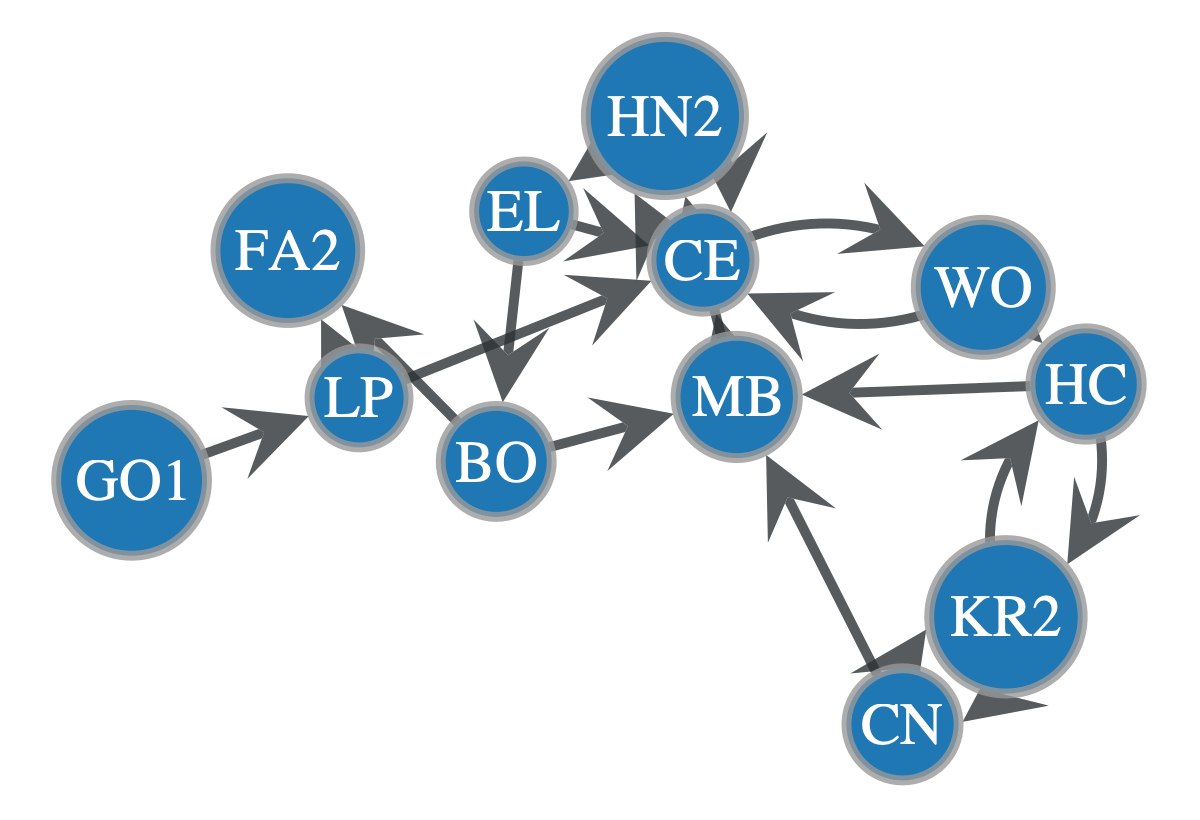

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1774157c0, at 0x1757d6900>

In [58]:
filter_lay = onion2.view_layers(['grade_1'])
search_res = onion2.searcher.search(g=filter_lay, 
                                    direction='bi', 
                                    max_dist=20, 
                                    show_plot=False
                                    )
v_colors = onionnet.visualisation.color_nodes(g=search_res, prop_name='layer')['v_color']
search_res.vp['v_color'] = v_colors
graph_draw(
    search_res,
    vertex_text=search_res.vp['name_decoded'], 
    pos=pos_sfdp, 
    vertex_fill_color=search_res.vp['v_color']
    )

## Bipartite graph creation

Earlier on we experimented with filtering the interlayers using lambda and some other functions. In OnionNet there is actually a dedicated way to do this kind of analysis between two layers of the network. This ignores intra-layer connections and filters to only nodes involved in the inter-layer links between these two layers, effectively creating a bipartite network. To do this use the `create_bipartite_gv` function

In [59]:
layer_1 = 'grade_1'
layer_2 = 'grade_2'
bipartite_gv = onion2.create_bipartite_gv(layer1=layer_1, layer2=layer_2)
bipartite_gv

<GraphView object, directed, with 19 vertices and 10 edges, 10 internal vertex properties, 6 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x17578e1e0, at 0x177416ab0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x17578e1e0, at 0x177416a80>, False), at 0x17578e1e0>

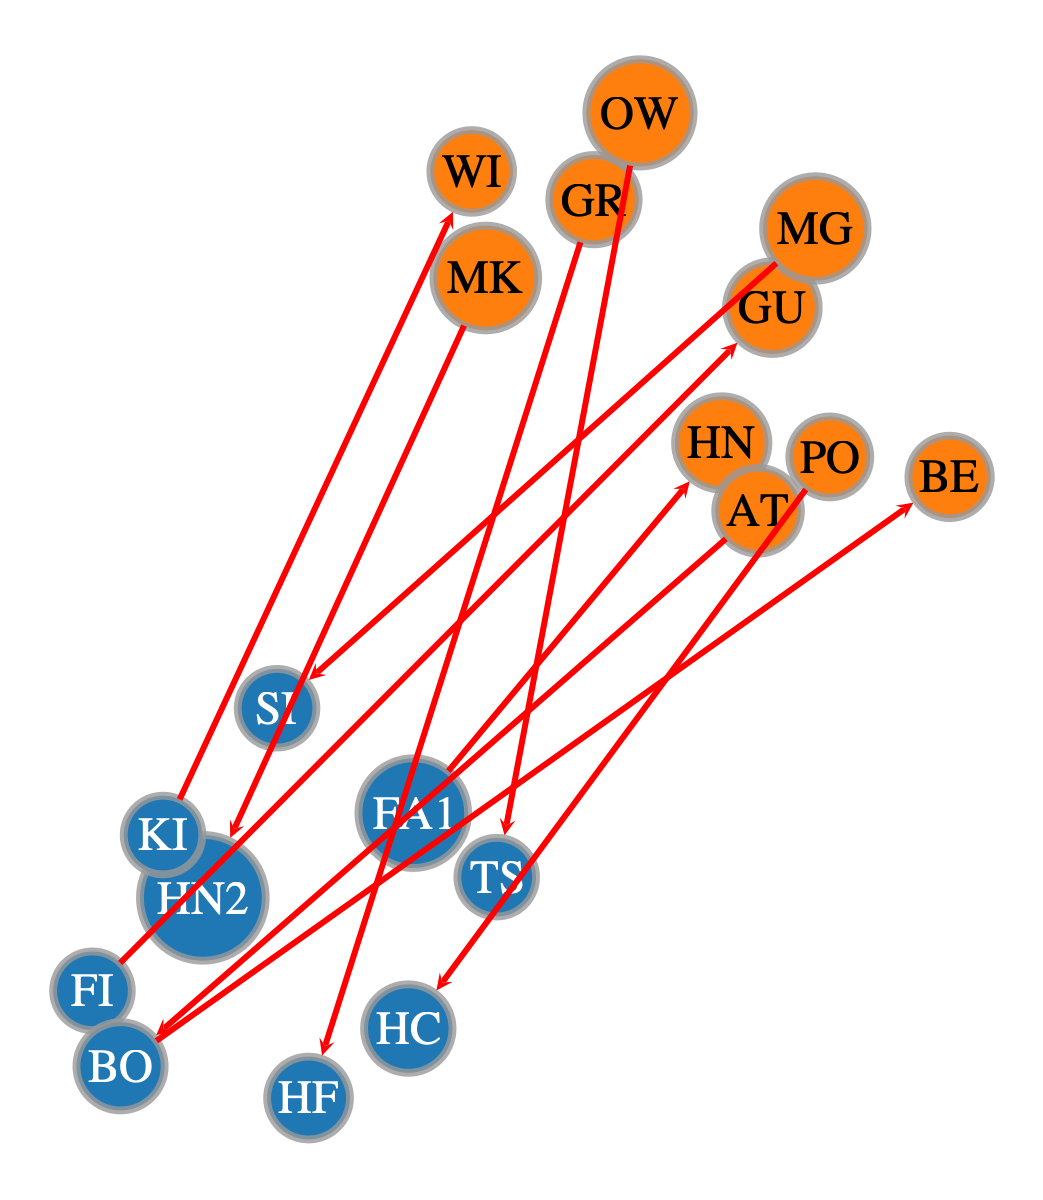

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x17578e1e0, at 0x17573b620>

In [60]:
graph_draw(bipartite_gv, 
           edge_pen_width=3.0,
           pos=pos_sfdp,
           vertex_text=search_res.vp['name_decoded'],
           vertex_fill_color=bipartite_gv.vp['v_color'], 
           edge_color=e_cols['e_color'],
           nodesfirst=True)

We could also view these with a more spread out layout 

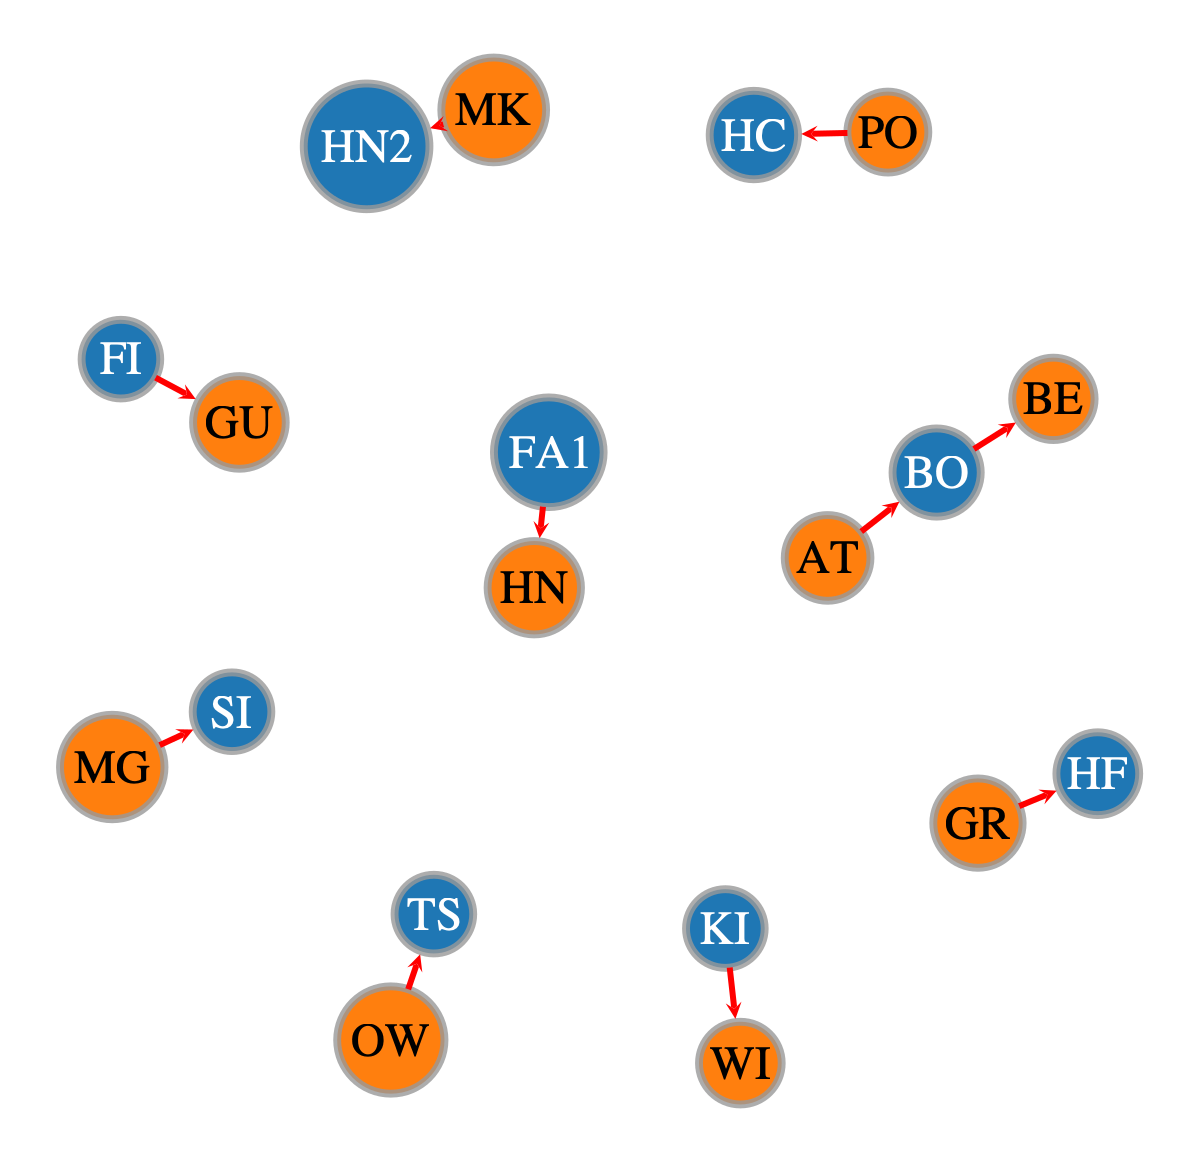

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x17578e1e0, at 0x17578dd60>

In [61]:
graph_draw(bipartite_gv, 
           edge_pen_width=3.0,
           vertex_text=search_res.vp['name_decoded'],
           vertex_fill_color=bipartite_gv.vp['v_color'], 
           edge_color=e_cols['e_color'],
           nodesfirst=True)

Or we can even create a special bipartite layout to do this

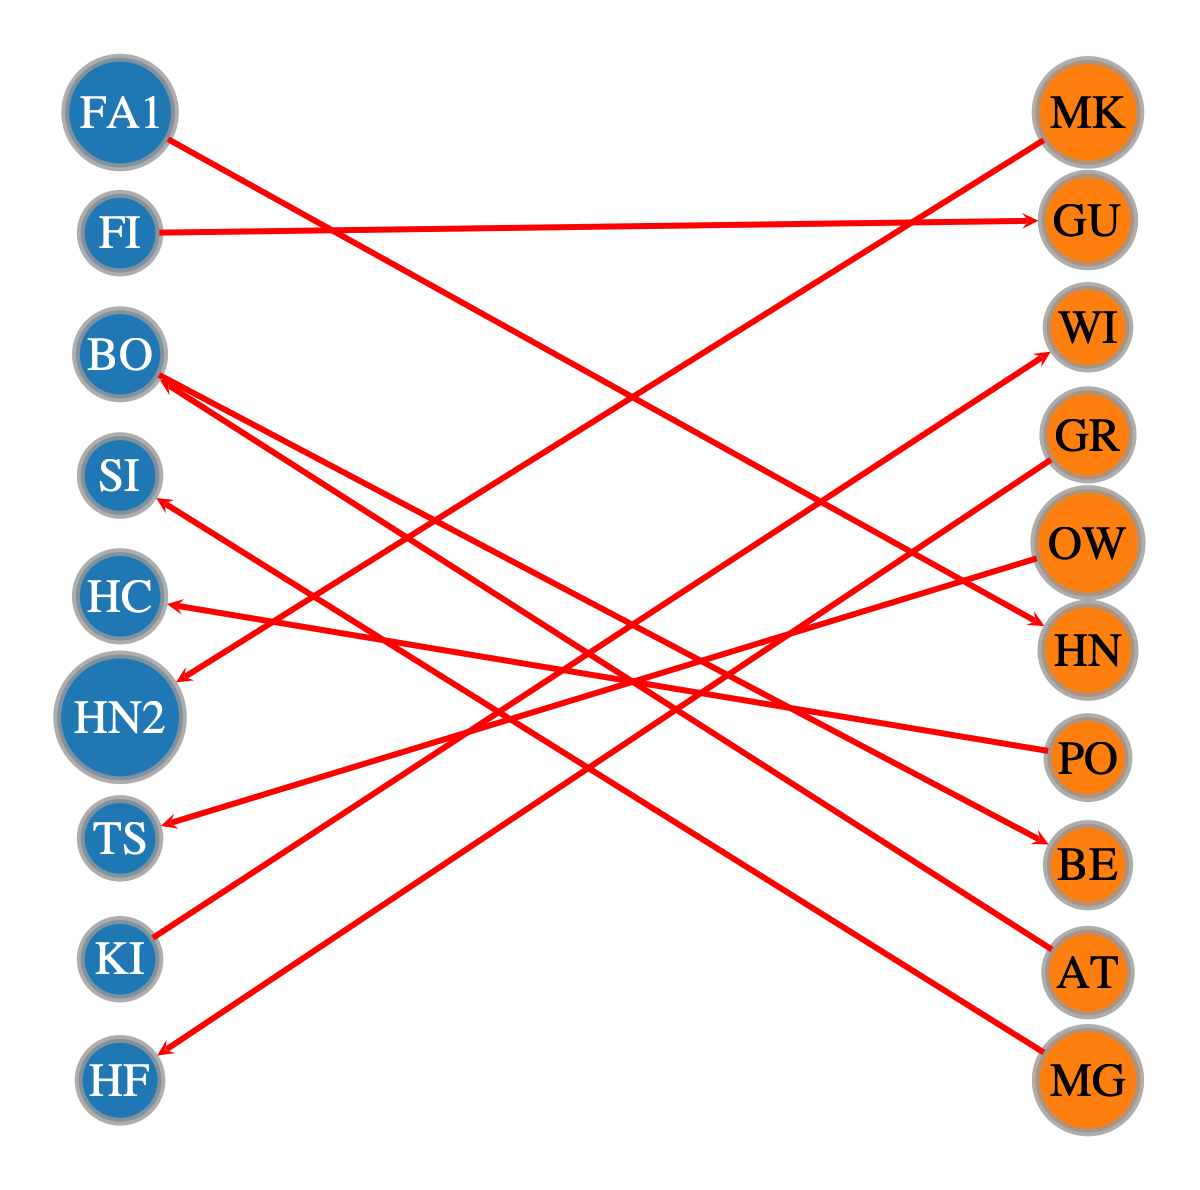

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x17578e1e0, at 0x1757b3620>

In [62]:
pos_bipartite = onionnet.visualisation.layout_by_layer(bipartite_gv)

graph_draw(bipartite_gv, 
           edge_pen_width=3.0,
           pos=pos_bipartite,
           vertex_text=search_res.vp['name_decoded'],
           vertex_fill_color=bipartite_gv.vp['v_color'], 
           edge_color=e_cols['e_color'],
           nodesfirst=True)

We can also order this to improve the ability to discern patterns in the connections. This allows us to more easily see the double connection between BO.

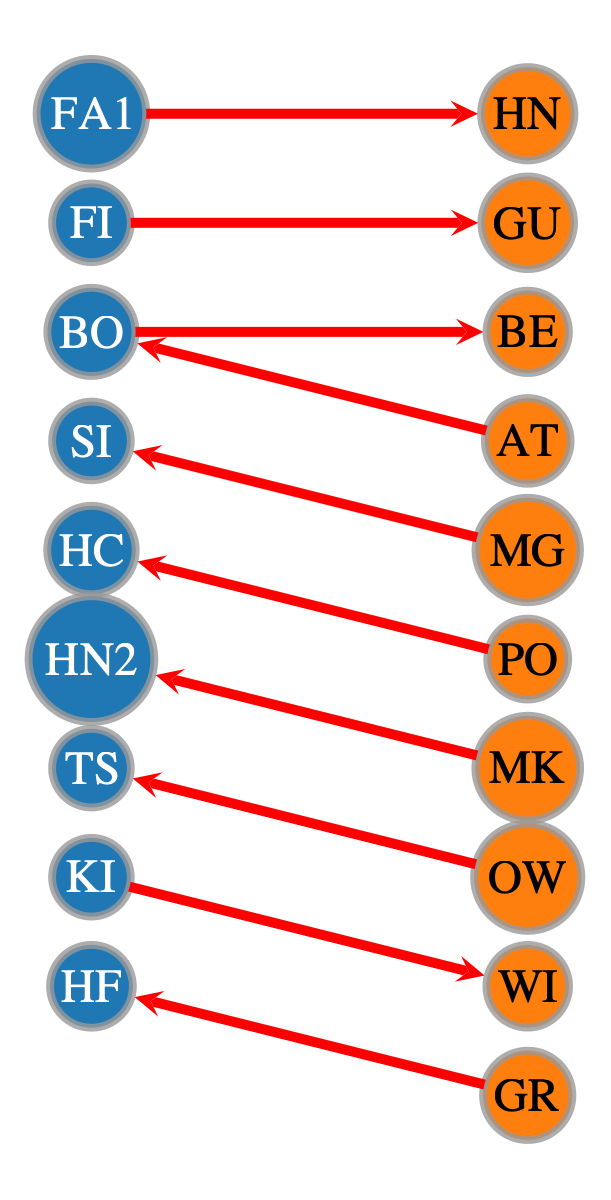

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x17578e1e0, at 0x1757d5340>

In [63]:
pos_bipartite_ordered = onionnet.visualisation.bipartite_ordered_layout(bipartite_gv, left_val='grade_1', right_val='grade_2', 
                                                                        vertical_spacing=100, horizontal_spacing=400)

graph_draw(bipartite_gv, 
           edge_pen_width=5.0,
           pos=pos_bipartite_ordered,
           vertex_text=search_res.vp['name_decoded'],
           vertex_fill_color=bipartite_gv.vp['v_color'], 
           edge_color=e_cols['e_color'],
           nodesfirst=True)

## Exporting filtered graphs

What if we want to now export the data from our filtered network into a dataframe or list, etc.? OnionNet includes a function to do just that: `export_info()`. By default this will include all node properties. Note however that they will be in the encoded integer format unless we have already decoded certain properties, like we did for `name_decoded` earlier.

In [64]:
onionnet.exporter.export_info(search_res, mode='v')

v_int  layer_hash  node_id_hash  node_id  name  _pos  layer layer_decoded  \
0       0           0             0        0     0     0      0       grade_1   
1       1           0             1        1     1     1      0       grade_1   
2       3           0             3        3     3     3      0       grade_1   
3       6           0             6        6     6     6      0       grade_1   
4       8           0             8        8     8     8      0       grade_1   
5      10           0            10       10    10    10      0       grade_1   
6      17           0            17       17    17    17      0       grade_1   
7      20           0            20       20    20    20      0       grade_1   
8      21           0            21       21    21    21      0       grade_1   
9      23           0            23       23    23    23      0       grade_1   
10     28           0            28       28    28    28      0       grade_1   
11     31           0            31       31    31    31      0       grade_1   

   node_id_decoded name_decoded  \
0                0          GO1   
1                1           LP   
2                3           WO   
3                6           CE   
4                8          FA2   
5               10           BO   
6               17           HC   
7               20          KR2   
8               21           MB   
9               23          HN2   
10              28           CN   
11              31           EL   

                                              v_color  
0   [0.12156862745098039, 0.4666666666666667, 0.70...  
1   [0.12156862745098039, 0.4666666666666667, 0.70...  
2   [0.12156862745098039, 0.4666666666666667, 0.70...  
3   [0.12156862745098039, 0.4666666666666667, 0.70...  
4   [0.12156862745098039, 0.4666666666666667, 0.70...  
5   [0.12156862745098039, 0.4666666666666667, 0.70...  
6   [0.12156862745098039, 0.4666666666666667, 0.70...  
7   [0.12156862745098039, 0.4666666666666667, 0.70...  
8   [0.12156862745098039, 0.4666666666666667, 0.70...  
9   [0.12156862745098039, 0.4666666666666667, 0.70...  
10  [0.12156862745098039, 0.4666666666666667, 0.70...  
11  [0.12156862745098039, 0.4666666666666667, 0.70...

We can also do the same for edges

In [65]:
onionnet.exporter.export_info(search_res, mode='e')

e_id  source  target  source_id  target_id  source_layer  target_layer  \
0      0       0       1          0          0             0             0   
1      1       1       8          1          1             0             0   
2      2       1       6          1          2             0             0   
3      5       3       6          3          2             0             0   
4      6       3      17          3          5             0             0   
5     10       6       3          6          3             0             0   
6     11       6      23          6          7             0             0   
7     16      10       8          9          1             0             0   
8     17      10      21          9         10             0             0   
9     32      17      20         16         15             0             0   
10    33      17      21         16         10             0             0   
11    38      20      17         19          5             0             0   
12    39      20      28         19         16             0             0   
13    40      21       6         20          2             0             0   
14    41      21      23         20          7             0             0   
15    44      23       6         22          2             0             0   
16    45      23      31         22         17             0             0   
17    53      28      21         27         10             0             0   
18    54      28      20         27         15             0             0   
19    59      31      10         30          9             0             0   
20    60      31       6         30          2             0             0   

    interlayer               e_color  
0            0  [0.5, 0.5, 0.5, 1.0]  
1            0  [0.5, 0.5, 0.5, 1.0]  
2            0  [0.5, 0.5, 0.5, 1.0]  
3            0  [0.5, 0.5, 0.5, 1.0]  
4            0  [0.5, 0.5, 0.5, 1.0]  
5            0  [0.5, 0.5, 0.5, 1.0]  
6            0  [0.5, 0.5, 0.5, 1.0]  
7            0  [0.5, 0.5, 0.5, 1.0]  
8            0  [0.5, 0.5, 0.5, 1.0]  
9            0  [0.5, 0.5, 0.5, 1.0]  
10           0  [0.5, 0.5, 0.5, 1.0]  
11           0  [0.5, 0.5, 0.5, 1.0]  
12           0  [0.5, 0.5, 0.5, 1.0]  
13           0  [0.5, 0.5, 0.5, 1.0]  
14           0  [0.5, 0.5, 0.5, 1.0]  
15           0  [0.5, 0.5, 0.5, 1.0]  
16           0  [0.5, 0.5, 0.5, 1.0]  
17           0  [0.5, 0.5, 0.5, 1.0]  
18           0  [0.5, 0.5, 0.5, 1.0]  
19           0  [0.5, 0.5, 0.5, 1.0]  
20           0  [0.5, 0.5, 0.5, 1.0]

Note the differences between source and targets (should check: todo)